# lesson 5

本节看看如何构建地图。包括：

- Static maps
- Interactive Leaflet maps (Folium and mplleaflet)

使用的库包括：

- Matplotlib(与geopandas整合，构建static maps)
- Folium(基于Leaflet构建交互式地图)
- mpleaflet(可以很容易地将matplotlib图转为可交互的leaflet地图)
- contextily(添加basemaps)

## static maps

首先，数据在dataE5文件夹下，有许多shape文件备用。前面也有用到过geopandas的plot方法，它就是调用了matplotlib的pyplot函数。现在再看看新例子：

In [1]:
import geopandas as gpd
from pyproj import CRS
import matplotlib.pyplot as plt
%matplotlib inline

# Filepaths
grid_fp = "dataE5/TravelTimes_to_5975375_RailwayStation.shp"
roads_fp = "dataE5/roads.shp"
metro_fp = "dataE5/metro.shp"

# Read files
grid = gpd.read_file(grid_fp)
roads = gpd.read_file(roads_fp)
metro = gpd.read_file(metro_fp)

绘图前要先检查坐标系是否一致，不一致地要转换到相同坐标系下。

In [2]:
# Check the crs of each layer
print(roads.crs)
print(metro.crs)
print(grid.crs)

epsg:2392
epsg:2392
epsg:3067


In [3]:
# Roads and the metro are in an old Finnish crs, while the grid is in ETRS89 / TM35FIN:
print("Roads crs:", CRS(roads.crs).name)
print("Metro crs:", CRS(metro.crs).name)
print("Grid crs: ",CRS(grid.crs).name)

Roads crs: KKJ / Finland zone 2
Metro crs: KKJ / Finland zone 2
Grid crs:  ETRS89 / TM35FIN(E,N)


In [4]:
# Reproject geometries to ETRS89 / TM35FIN based on the grid crs:
roads = roads.to_crs(crs=grid.crs)
metro = metro.to_crs(crs=grid.crs)

In [5]:
# Now the layers should be in the same crs
roads.crs == metro.crs == grid.crs

True

坐标系转换完成之后，就可以绘图了。

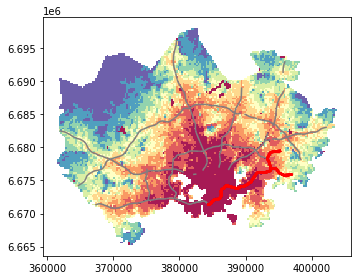

In [7]:
# Visualize the travel times into 9 classes using "Quantiles" classification scheme
my_map = grid.plot(column="car_r_t", linewidth=0.03, cmap="Spectral", scheme="quantiles", k=9, alpha=0.9)

# Add roads on top of the grid
# (use ax parameter to define the map on top of which the second items are plotted)
roads.plot(ax=my_map, color="grey", linewidth=1.5)

# Add metro on top of the previous map
metro.plot(ax=my_map, color="red", linewidth=2.5)

# Remove the empty white-space around the axes
plt.tight_layout()

# Save the figure as png file with resolution of 300 dpi
outfp = "static_map.png"
plt.savefig(outfp, dpi=300)

# Save the figure as svg file
outfp = "static_map.svg"
plt.savefig(outfp, format='svg')

从上述代码可以看到，可选的参数有：scheme 定义分类框架，cmap设置地图颜色等。还可以进一步精细控制坐标轴等：

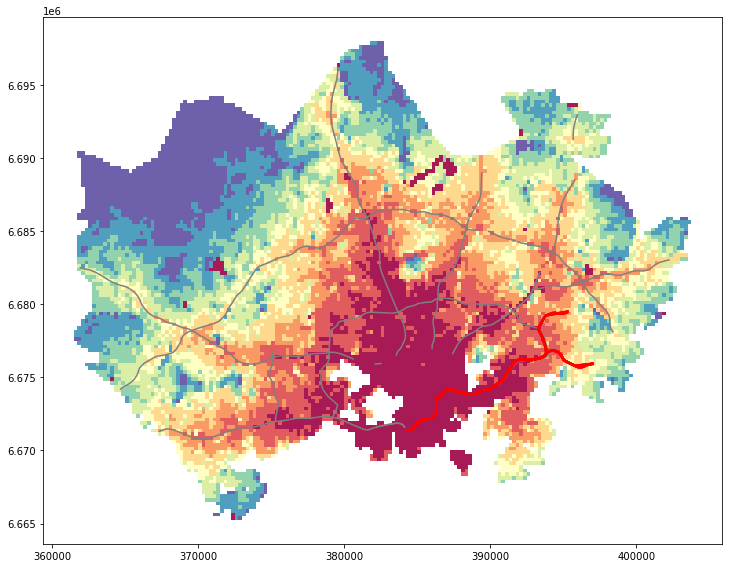

In [8]:
# For better control of the figure and axes, use the plt.subplots function before plotting the layers
# https://matplotlib.org/3.1.0/gallery/subplots_axes_and_figures/subplots_demo.html#a-figure-with-just-one-subplot

# Control figure size in here
fig, ax = plt.subplots(figsize=(12,8))

# Visualize the travel times into 9 classes using "Quantiles" classification scheme
grid.plot(ax=ax, column="car_r_t", linewidth=0.03, cmap="Spectral", scheme="quantiles", k=9, alpha=0.9)

# Add roads on top of the grid
# (use ax parameter to define the map on top of which the second items are plotted)
roads.plot(ax=ax, color="grey", linewidth=1.5)

# Add metro on top of the previous map
metro.plot(ax=ax, color="red", linewidth=2.5)

# Remove the empty white-space around the axes
plt.tight_layout()

# Save the figure as png file with resolution of 300 dpi
outfp = "static_map2.png"
plt.savefig(outfp, dpi=300)

在实际应用中，我们经常需要将底图加到我们数据上。这项内容可以使用背景map tiles来较容易地实现，map tiles提供者有OpenStreetMap，Stamen Design等。一个叫做contextily的python库可以用来快速地获取地理空间栅格文件并将它们增加到地图中。地图tiles的典型坐标系是 Web Mercator projection (EPSG:3857)。接下来看看如何在上面的数据下放置底图。首先读取数据。

In [10]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
%matplotlib inline

# Filepaths
grid_fp = "dataE5/TravelTimes_to_5975375_RailwayStation.shp"

# Read data
grid = gpd.read_file(grid_fp)
grid.head(2)

,car_m_d,car_m_t,car_r_d,car_r_t,from_id,pt_m_d,pt_m_t,pt_m_tt,pt_r_d,pt_r_t,pt_r_tt,to_id,walk_d,walk_t,geometry
0,32297,43,32260,48,5785640,32616,116,147,32616,108,139,5975375,32164,459,"POLYGON ((382000.000 6697750.000, 381750.000 6..."
1,32508,43,32471,49,5785641,32822,119,145,32822,111,133,5975375,29547,422,"POLYGON ((382250.000 6697750.000, 382000.000 6..."


同样需要处理坐标系：

In [11]:
grid.crs

<Projected CRS: EPSG:3067>
Name: ETRS89 / TM35FIN(E,N)
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Finland - onshore and offshore.
- bounds: (19.08, 58.84, 31.59, 70.09)
Coordinate Operation:
- name: TM35FIN
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989 ensemble
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

可以看到，需要转换坐标系到ESPG 3857 projection (Web Mercator)

In [12]:
# Reproject to EPSG 3857
data = grid.to_crs(epsg=3857)
data.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [13]:
data.head(2)

,car_m_d,car_m_t,car_r_d,car_r_t,from_id,pt_m_d,pt_m_t,pt_m_tt,pt_r_d,pt_r_t,pt_r_tt,to_id,walk_d,walk_t,geometry
0,32297,43,32260,48,5785640,32616,116,147,32616,108,139,5975375,32164,459,"POLYGON ((2767221.646 8489079.101, 2766716.966..."
1,32508,43,32471,49,5785641,32822,119,145,32822,111,133,5975375,29547,422,"POLYGON ((2767726.329 8489095.521, 2767221.646..."


可以看到geometry数据已经变化，坐标已经完成转换了。现在通过使用contextily的.add_basemap()函数可以从外部网络资源增加底图到数据上。

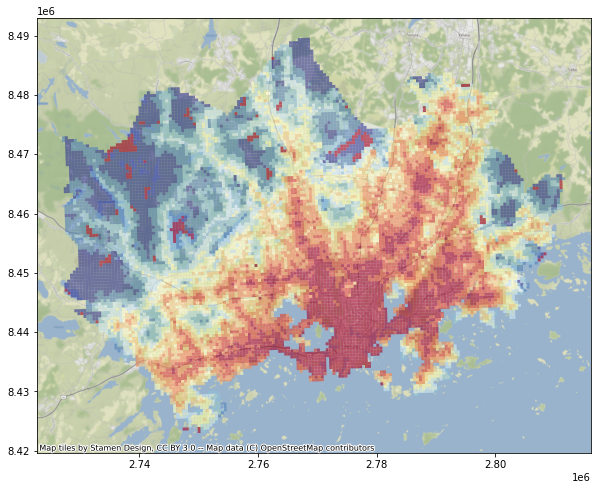

In [15]:
# Control figure size in here
fig, ax = plt.subplots(figsize=(12,8))

# Plot the data
data.plot(ax=ax, column='pt_r_t', cmap='RdYlBu', linewidth=0, scheme="quantiles", k=9, alpha=0.6)

# Add basemap
ctx.add_basemap(ax)

可以看到，现在地图有了底图，默认地使用了ST_Terrain的风格，风格来自[Stamen Design](http://maps.stamen.com/#terrain/12/37.7706/-122.3782)。当然还有很多其他的数据源和地图风格可以使用，如下命令可以查看：

In [16]:
dir(ctx.tile_providers)

['_OSM_A',
 '_OSM_B',
 '_OSM_C',
 '_ST_TERRAIN',
 '_ST_TERRAIN_BACKGROUND',
 '_ST_TERRAIN_LABELS',
 '_ST_TERRAIN_LINES',
 '_ST_TONER',
 '_ST_TONER_BACKGROUND',
 '_ST_TONER_HYBRID',
 '_ST_TONER_LABELS',
 '_ST_TONER_LINES',
 '_ST_TONER_LITE',
 '_T_WATERCOLOR',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__getattr__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'deprecated_sources',
 'sys',
 'warnings']

上面结果中，所有大写字母的名字代表了不同的底图风格类型。所有ST开头的来自 Stamen Design风格，OSM_ 的是openstreetmap提供的基本地图贴片风格。A B C 代表不同的tile 服务，风格是一样的。

可以通过在add_basemap()函数中设置url参数来设置tile提供者，如下所示：

<ipython-input-19-1972febb267c>:8: FutureWarning: The "contextily.tile_providers" module is deprecated and will be removed in contextily v1.1. Please use "contextily.providers" instead.
  ctx.add_basemap(ax, url=ctx.tile_providers.OSM_A)
<ipython-input-19-1972febb267c>:8: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.
  ctx.add_basemap(ax, url=ctx.tile_providers.OSM_A)


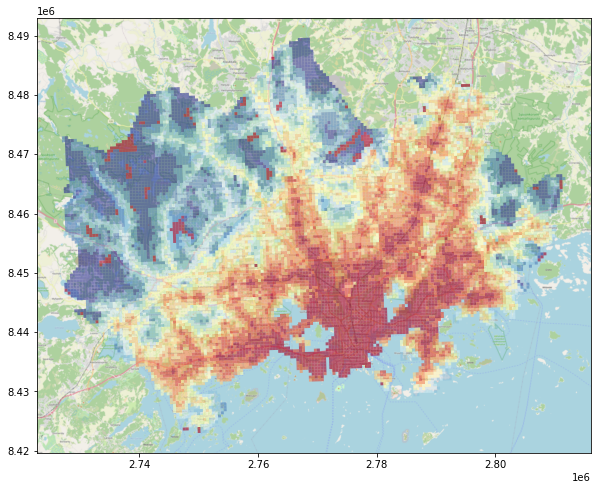

In [19]:
# Control figure size in here
fig, ax = plt.subplots(figsize=(12,8))

# Plot the data
data.plot(ax=ax, column='pt_r_t', cmap='RdYlBu', linewidth=0, scheme="quantiles", k=9, alpha=0.6)

# Add basemap with `ST_TONER` style
ctx.add_basemap(ax, url=ctx.tile_providers.OSM_A)

现在可以看到底图已经改变了，因为它来自openstreetmap。下面取一部分数据展示到底图上，再看看OSM底图的风格。

<ipython-input-20-4ee3f3c88643>:11: FutureWarning: The "contextily.tile_providers" module is deprecated and will be removed in contextily v1.1. Please use "contextily.providers" instead.
  ctx.add_basemap(ax, url=ctx.tile_providers.OSM_A)
<ipython-input-20-4ee3f3c88643>:11: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.
  ctx.add_basemap(ax, url=ctx.tile_providers.OSM_A)


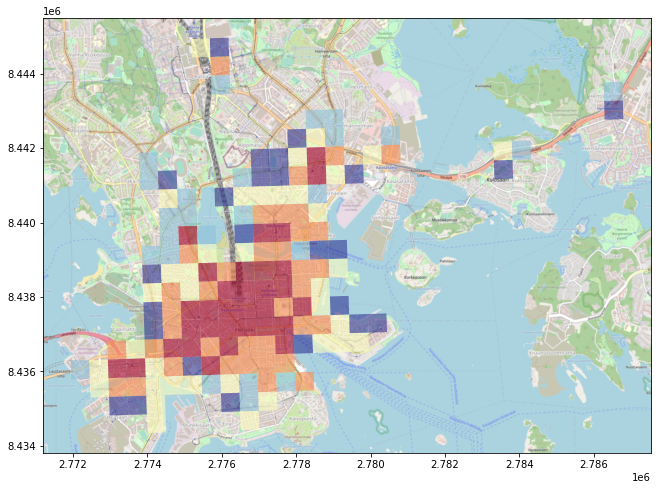

In [20]:
# Control figure size in here
fig, ax = plt.subplots(figsize=(12,8))

# Subset the data to seel only grid squares near the destination
subset = data.loc[(data['pt_r_t']>=0) & (data['pt_r_t']<=15)]

# Plot the data from subset
subset.plot(ax=ax, column='pt_r_t', cmap='RdYlBu', linewidth=0, scheme="quantiles", k=5, alpha=0.6)

# Add basemap with `OSM_A` style
ctx.add_basemap(ax, url=ctx.tile_providers.OSM_A)

上述底图展示了很多细节，如果不需要那么多，可以设置zoom参数，获取分辨率更低一些的底图。zoom的级别是1-19，越大代表细节越多。

<ipython-input-21-a095024c1b0e>:8: FutureWarning: The "contextily.tile_providers" module is deprecated and will be removed in contextily v1.1. Please use "contextily.providers" instead.
  ctx.add_basemap(ax, zoom=11, url=ctx.tile_providers.OSM_A)
<ipython-input-21-a095024c1b0e>:8: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.
  ctx.add_basemap(ax, zoom=11, url=ctx.tile_providers.OSM_A)


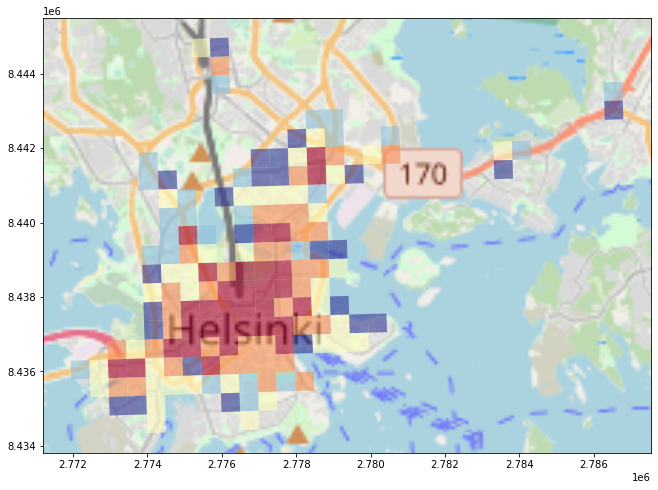

In [21]:
# Control figure size in here
fig, ax = plt.subplots(figsize=(12,8))

# Plot the data from subset
subset.plot(ax=ax, column='pt_r_t', cmap='RdYlBu', linewidth=0, scheme="quantiles", k=5, alpha=0.6)

# Add basemap with `OSM_A` style using zoom level of 11
ctx.add_basemap(ax, zoom=11, url=ctx.tile_providers.OSM_A)

另外可以通过使用ax.set_xlim()和ax.set_ylim()来设置图片范围。

<ipython-input-22-ffdcbcae2b19>:9: FutureWarning: The "contextily.tile_providers" module is deprecated and will be removed in contextily v1.1. Please use "contextily.providers" instead.
  ctx.add_basemap(ax, zoom=11, attribution="Travel time data by Digital Geography Lab, Map Data © OpenStreetMap contributors", url=ctx.tile_providers.OSM_A)
<ipython-input-22-ffdcbcae2b19>:9: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.
  ctx.add_basemap(ax, zoom=11, attribution="Travel time data by Digital Geography Lab, Map Data © OpenStreetMap contributors", url=ctx.tile_providers.OSM_A)


(8430000.0, 8470000.0)

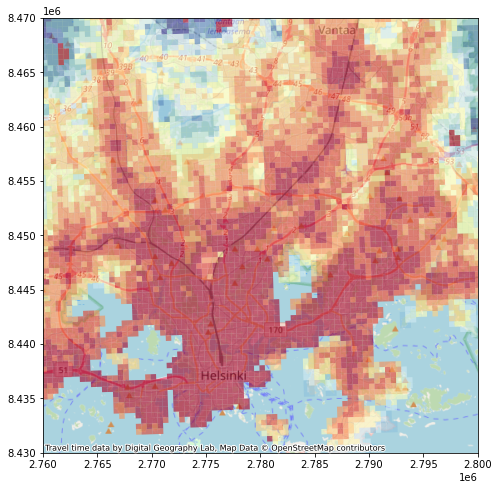

In [22]:
# Control figure size in here
fig, ax = plt.subplots(figsize=(12,8))

# Plot the data
data.plot(ax=ax, column='pt_r_t', cmap='RdYlBu', linewidth=0, scheme="quantiles", k=9, alpha=0.6)

# Add basemap with `OSM_A` style using zoom level of 11
# Modify the attribution
ctx.add_basemap(ax, zoom=11, attribution="Travel time data by Digital Geography Lab, Map Data © OpenStreetMap contributors", url=ctx.tile_providers.OSM_A)

# Crop the figure
ax.set_xlim(2760000, 2800000)
ax.set_ylim(8430000, 8470000)

当然，也可以使用其他的tile map services的地图tiles。有一个list可以看有哪些map services：[leaflet-providers](http://leaflet-extras.github.io/leaflet-providers/preview/)。注意当使用来自不同资源的map tile时，需要传递url 地址给tile的provider。

## Interactive maps

这里交互地图基于leaflet地图。主要使用folium，它们能将geopandas中的数据转为 Interactive maps。

Folium是一个可以创建交互地图的python库。先创建一个Map instance：

In [27]:
import folium

# Create a Map instance
m = folium.Map(location=[60.25, 24.8], zoom_start=10, control_scale=True)
m

In [29]:
# Let's change the basemap style to 'Stamen Toner'
m = folium.Map(location=[40.730610, -73.935242], tiles='Stamen Toner',
                zoom_start=12, control_scale=True, prefer_canvas=True)

m

现在向底图上添加图层：

In [30]:
# Create a Map instance
m = folium.Map(location=[60.20, 24.96],
    zoom_start=12, control_scale=True)

# Add marker
# Run: help(folium.Icon) for more info about icons
folium.Marker(
    location=[60.20426, 24.96179],
    popup='Kumpula Campus',
    icon=folium.Icon(color='green', icon='ok-sign'),
).add_to(m)

#Show map
m

添加geopandas的数据的话，要先将数据转为GEOJSON。

In [31]:
points.head()

,address,id,geometry
0,"Kampinkuja 1, 00100 Helsinki, Finland",1001,POINT (24.93017 60.16837)
1,"Kaivokatu 8, 00101 Helsinki, Finland",1002,POINT (24.94189 60.16987)
2,"Hermanstads strandsväg 1, 00580 Helsingfors, F...",1003,POINT (24.97740 60.18736)
3,"Itäväylä, 00900 Helsinki, Finland",1004,POINT (25.09196 60.21448)
4,"Tyynenmerenkatu 9, 00220 Helsinki, Finland",1005,POINT (24.92148 60.15658)


In [32]:
# Convert points to GeoJSON
points_gjson = folium.features.GeoJson(points, name="Public transport stations")
# Create a Map instance
m = folium.Map(location=[60.25, 24.8], tiles = 'cartodbpositron', zoom_start=11, control_scale=True)

# Add points to the map instance
points_gjson.add_to(m)

# Alternative syntax for adding points to the map instance
#m.add_child(points_gjson)

#Show map
m

还可以绘制其他各类地图，后面有实际用到再补充。

更多gis可视化的内容可以参考[hydrus](https://github.com/OuyangWenyu/hydrus)